<a href="https://colab.research.google.com/github/rinaove/KAGGLE/blob/main/1%EC%A3%BC%EC%B0%A8_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1주차_타이타닉_필사

* 목표: top4% 모델링 기법은 뭐가 다를까
* 목표: 몰랐던 EDA, 특히 시각화 방법 필사
* 목표: 새로운 모델링 기법 익히기
* 공부법: 모르는 코드는 챗지피티에게 물어보기 + 텍스트 기입


## 1. Introduction
- - -
* 피쳐 분석
* 피쳐 엔지니어링
* 모델링

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

> 알게된 점

* `%matplotlib inline`은 matplotlib으로 만든 그래프를 노트북의 셀 바로 아래에 출력하도록 해줘요.
  * 즉, plt.show()를 따로 안 해도 그래프가 셀 결과로 표시돼요
  * 최신 Jupyter에서는 %matplotlib inline 없이도 자동으로 그래프가 셀에 표시되는 경우가 많아요
* `from collections import Counter`는 파이썬 표준 라이브러리인 collections 모듈에서 Counter라는 클래스를 가져오는 코드입니다
  * `Counter`는 리스트, 문자열 같은 iterable 데이터에서 요소의 개수를 세는 데 특화된 자료구조예요.
    * `result = Counter(data)`시 출력 데이터는 딕셔너리 형태로 합산됨


> 라이브러리 정리

* `Pandas`: 데이터 로딩/정리/조작 (CSV 불러오기, 결측치 처리 등)
* `Numpy`: 배열(ndarray) 기반. 벡터화 연산 지원
* `matplotlib.pyplot`: 데이터 시각화 (그래프 그리기)
* `seaborn`: matplotlib 위에 구축, 한 줄로 예쁜 통계 그래프 그려줌




## 2. Load and check data

### 2.1 Load data

In [ ]:
# Load data
##### Load train and Test set

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_file_path = '/content/drive/MyDrive/Kaggle/titanic /train.csv'
test_file_path = '/content/drive/MyDrive/Kaggle/titanic /test.csv'

train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [ ]:
# Outlier detection

def detect_outliers(df, n, features):
  """
  데이터프레임에서(df)에서 여러 features의 이상치를 탐색하고, Tukey method에 따라 n개 이상의 이상치를 보유한 행의 인덱스 반환
  """
  outlier_indices = []

  # iterate over features(columns)
  for col in features:
    # 1st quartile (25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[col], 75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    # Determine a list of indices of outliers for feature col
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    # append the found outlier indices for col to the list of outlier indices
    outlier_indices.extend(outlier_list_col)

  # select observations containing more than 2 outliers (중복)
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers

# detect outliers from Age, SibSp, Parch, and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])


> Tukey method

* 1분위 ~ 3분위수까지 IQR 설정 후 이상치 간격 설정 방법

> 알게 된 점
* df['col']은 Series 반환

    0    4
    1    5
    2    6
    Name: col, dtype: int64

* df[['col']]은 DataFrame 반환



        col
    0     4
    1     5
    2     6


* Counter(outlier_indices) 결과


    Counter({3: 3, 1: 2, 2: 1})


> 왜 n=2로 설정하였을까?

* 여러 특성(feature)에서 동시에 튄 값만 진짜 이상치로 봄
* feature가 많을수록 한두 개 컬럼에서 튀는 값은 자연스러움
* 그렇기에, 여러 feature에서 이상치로 걸러지는 행 = 진짜 이상치로 판단

> 🙄 나의 의문: 여러 변수에서 동시에 튄 경우를 '제거'하는게 맞을까?
* 이상치 값이 순수 오류 (Fare=9999)면 제거하는 게 맞지만, Fare/Age/SibSp의 극단값들은 '소수'의 의미있는 케이스일수도...
* 물론, 모델링을 통해 예측을 높이기 위해서는 중복되는 이상치를 제거하는 게 맞지만, EDA에서는 다르게 봐야할 것 같다.





In [ ]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


> 알게된 것

* 10개 중 3개는 높은 가격 Fare, 7개는 SibSp가 높음

In [ ]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

> 알게된 것

* `axis = 0`은 행 선택 제거

### 2.3 joining train and test set

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

> 알게된 것
* `train_len`은 나중에 train/test 다시 분리할 때 사용하려고 저장

### 2.4 check for null and missing values

In [ ]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,256
SibSp,0
Parch,0
Ticket,0
Fare,1


In [ ]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,170
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


In [ ]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

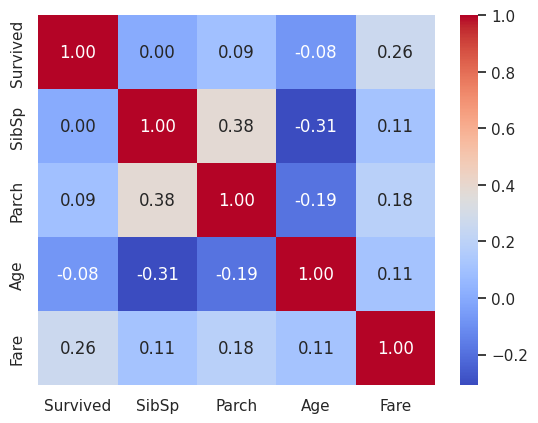

In [ ]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

> 알게 된 것

* Fare 피쳐가 생존율과 유의미한 관련이 있음
* 다른 피쳐가 의미 없다는 것은 아니며, 추가적으로 살펴볼 필요가 있다는 점 시사
* 앞으로 0,1 분류 문제는 변수 간 상관관계를 먼저 봐야겠다는 생각

/tmp/ipython-input-14-958971393.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")


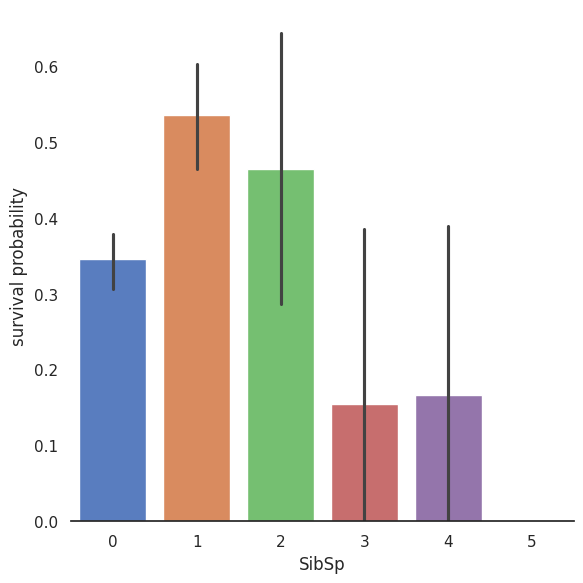

In [ ]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

> factorplot()이 없어졌대요...

* catplot()으로 대체
* SibSp(형제+배우자)수가 3명 이상부터 생존율이 현저하게 떨어짐 -> 피쳐 엔지니어링에서 고려

/tmp/ipython-input-15-2671301599.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6,palette="muted")


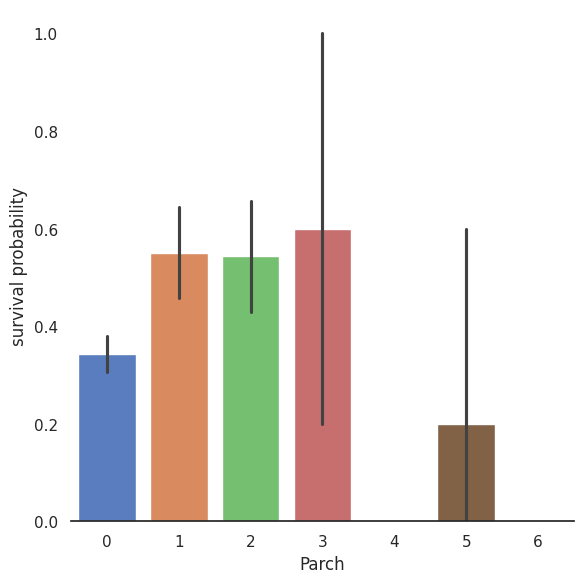

In [ ]:
# Explore Parch feature vs Survived

g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6,palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

> 알게 된 것

* Parch(부모+아이) 수가 4명 이상일수록 생존율이 급감
* Parch(부모+아이) 수가 3명일 때 분산이 큼

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


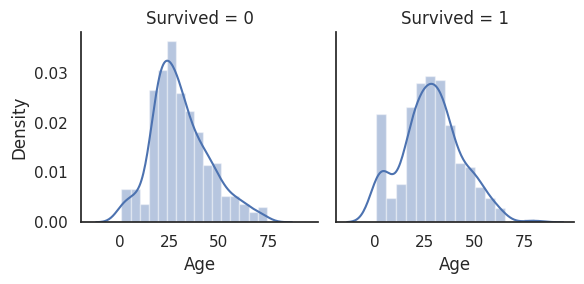

In [ ]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

> 알게 된 것

* 두 그래프 모두 정규분포처럼 보임
* 비슷해보이나, 나이가 어리거나 많은 승객들 간 차이가 보임

/tmp/ipython-input-17-54911406.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade=True)
/tmp/ipython-input-17-54911406.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue", shade=True)


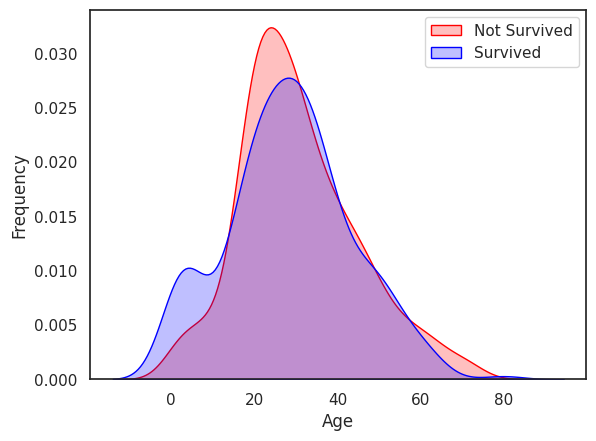

In [ ]:
# Explore Age distribution
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

> 알게된 것

* `ax=g`: g가 기존에 만들어둔 Axes 객체라면 이 KDE 플롯은 새로운 그래프를 만들지 않고 기존 g 그래프 위에 추가로 그림.

In [ ]:
dataset["Fare"].isnull().sum()

np.int64(1)

In [ ]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

/tmp/ipython-input-20-3545913686.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color='m', label="Skewness : %.2f"%dataset["Fare"].skew())


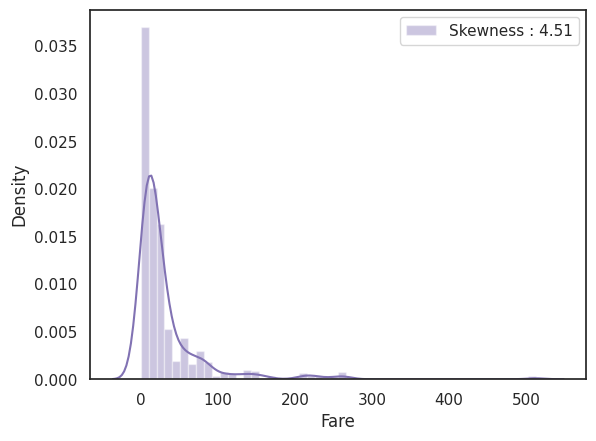

In [ ]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color='m', label="Skewness : %.2f"%dataset["Fare"].skew())
g = g.legend(loc="best")

In [ ]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

> 알게 된 것

* `distplot`: 예전 seaborn 버전에서 쓰였고, 최신 버전에선 sns.histplot + sns.kdeplot으로 나눠짐
* `loc="best"`: 범례 위치를 matplotlib이 자동으로 “가장 적절한 곳”에 배치
* `map()`: 컬럼의 각 값을 순회하며 함수를 적용



/tmp/ipython-input-22-846037914.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))


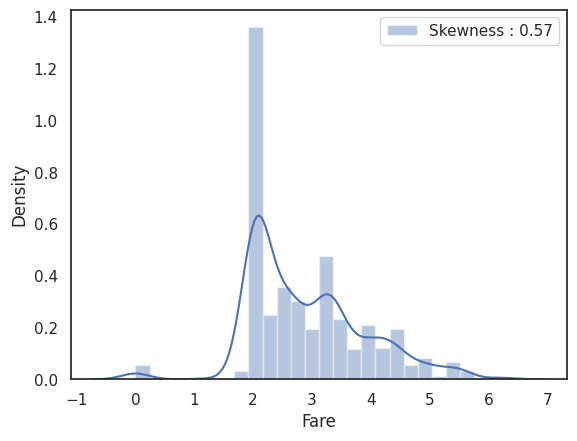

In [ ]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

## 범주형 변수

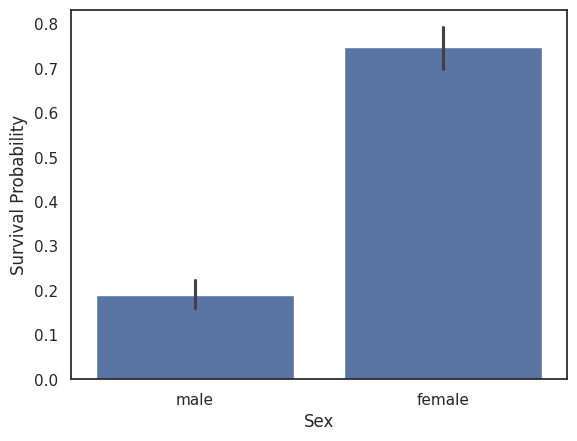

In [ ]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [ ]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


> 알게 된 것

* 성별에 따른 생존율 차이 -> 유의미하게 보임

/tmp/ipython-input-25-1886065125.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Pclass",y="Survived",data=train,kind="bar",height = 6 ,


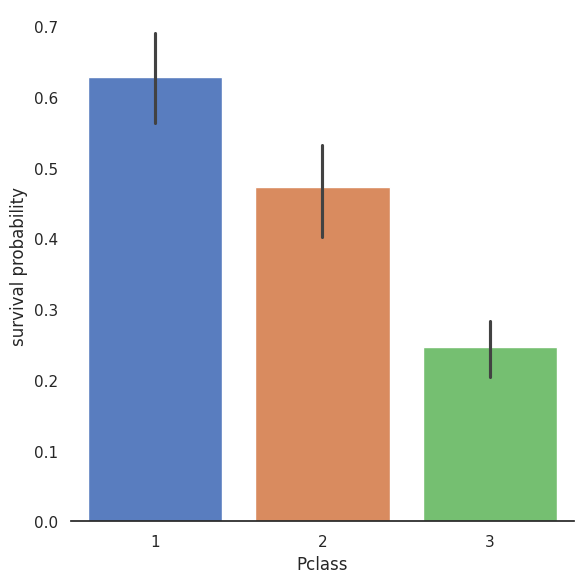

In [ ]:
# Explore Pclass vs Survived

g = sns.catplot(x="Pclass",y="Survived",data=train,kind="bar",height = 6 ,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

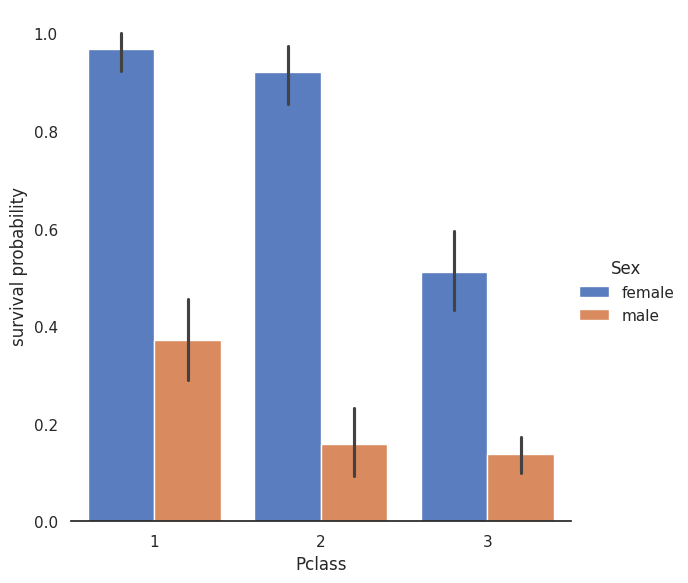

In [ ]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

> 알게 된 것

* `g.despine(left=True)`: 왼쪽(y축) 스파인 제거

In [ ]:
dataset["Embarked"].isnull().sum()

np.int64(2)

In [ ]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

/tmp/ipython-input-29-450840584.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Embarked", y="Survived", data=train, height=6, kind="bar", palette="muted")


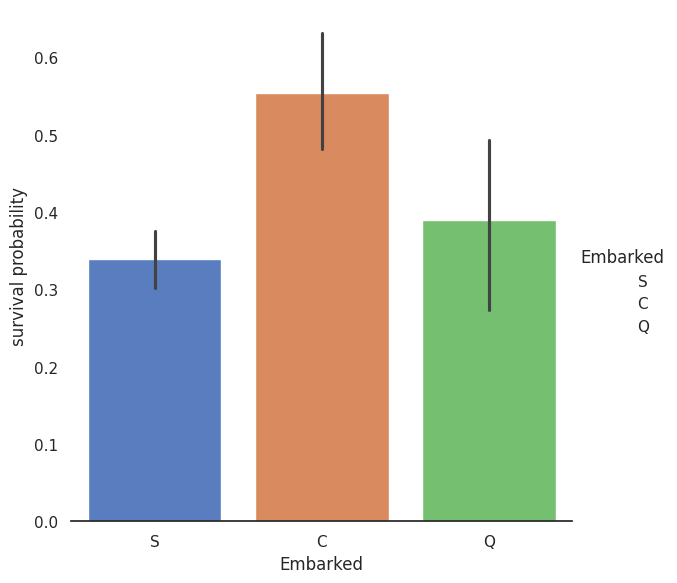

In [ ]:
# Explore Embarked vs Survived
g = sns.catplot(x="Embarked", y="Survived", data=train, height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/tmp/ipython-input-30-4017570468.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Pclass", col="Embarked", data=train, height=6, kind="count", palette="muted")


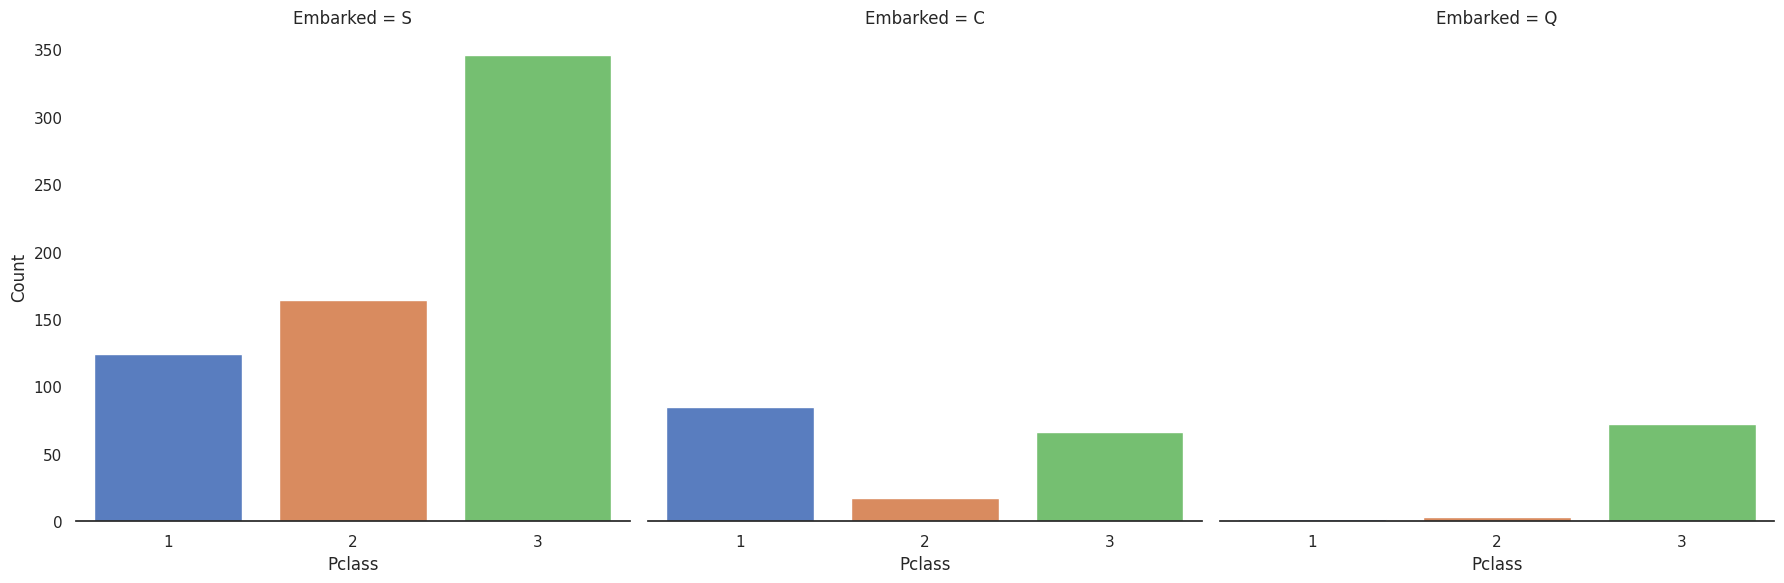

In [ ]:
# Explore Pclass vs Embarked
g = sns.catplot(x="Pclass", col="Embarked", data=train, height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

> 알게 된 것

* `col="Embarked"`: Embarked의 각 값(S, C, Q)마다 별도 서브플롯 생성

## 4. Filling missing Values

### 4.1 Age

* Age는 결측값이 많으나, subpopulation 차이가 유의미한 결과도 있었기에 열 삭제는 X
* 결측값 보완을 위해 Age와 연관있는 피쳐 선발 후 분석 (좋은 포인트)

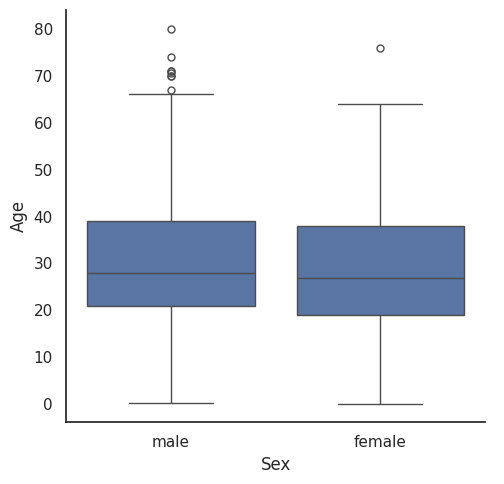

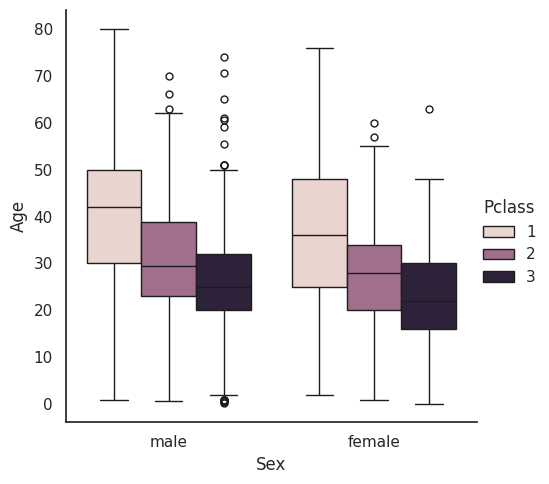

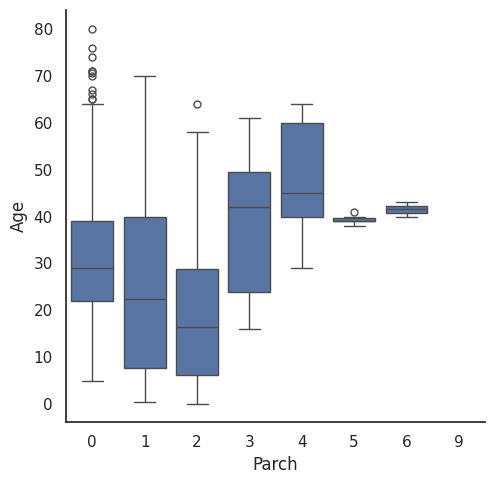

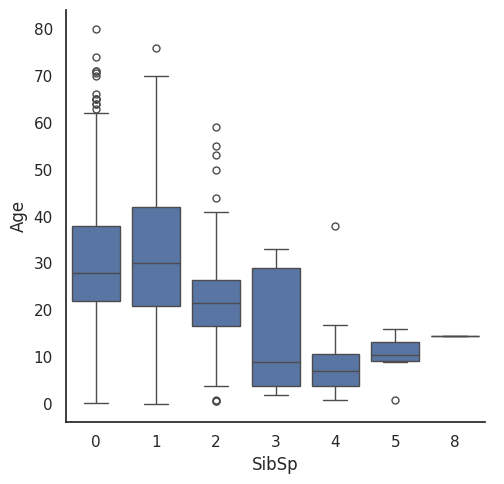

In [ ]:
# Explore Age vs Sex, Parch , Pclass and SibSP

g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

In [ ]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

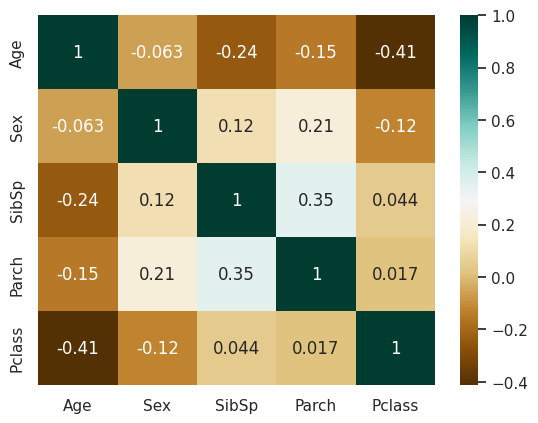

In [ ]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

> 알게 된 것

* catplot()에서는 나이가 높을수록 Parch값도 높아짐. (부모님 동반 가족이 많다는 것)
* 그러나 상관관계는 약한 음(-)을 띔. Parch값이 높아질수록 나이분포가 높아지는 경향을 띄나, 상관관계가 SibSp만큼 크지 않다는 점을 시사

In [ ]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
  age_med = dataset["Age"].median()
  age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
  if not np.isnan(age_pred):
    dataset["Age"].iloc[i] = age_pred
  else:
    dataset["Age"].iloc[i] = age_med

/tmp/ipython-input-34-2505142506.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset["Age"].iloc[i] = age_pred
/tmp/ipython-input-34-2505142506.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

> 코드 해석

* i번째 사람과 형제/배우자 수, 부모/자녀 수, 좌석 등급이 같은 사람들의 나이의 중앙값을 계산해 age_pred에 저장

* 왜 이렇게 함?
  * 결측된 Age를 단순 평균으로 채우면 이상치 영향 받음. 비슷한 가족구성/좌석등급의 사람들끼리 나이가 비슷할 가능성이 높으니 이렇게 중앙값으로 채움

> IF not

* `not np.isnan(age_pred)`: age_pred가 숫자라면 True값

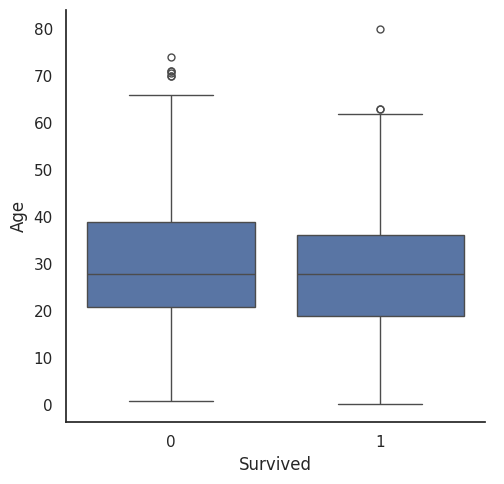

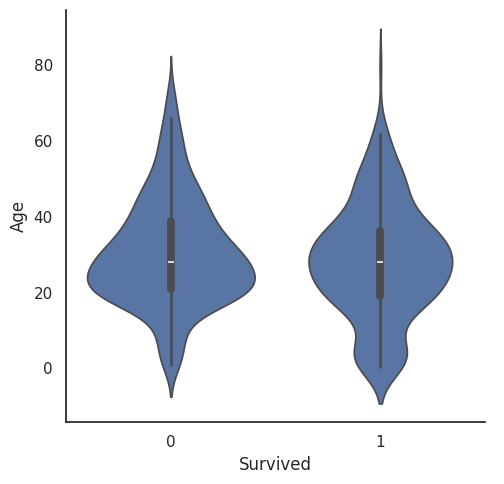

In [ ]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

## 5. Feature engineering

### 5.1 Name/Title

In [ ]:
dataset["Name"].head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


In [ ]:
# Get Title from Name

dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

,Title
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr


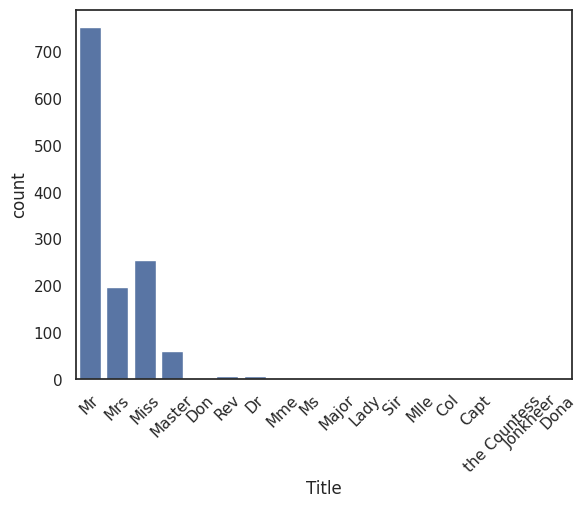

In [ ]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [ ]:
print(dataset["Title"].isnull().sum())
print(dataset["Title"].unique())

0
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


In [ ]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/tmp/ipython-input-41-137898062.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])


[Text(0, 0, 'Master'),
 Text(1, 0, 'Miss/Ms/Mme/Mlle/Mrs'),
 Text(2, 0, 'Mr'),
 Text(3, 0, 'Rare')]

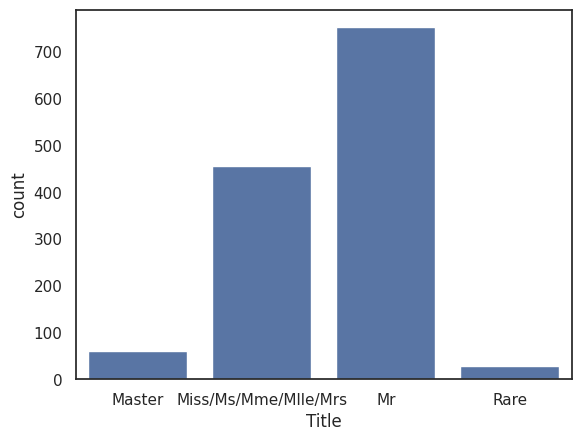

In [ ]:
g = sns.countplot(x="Title", data=dataset) # X축 설정
g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

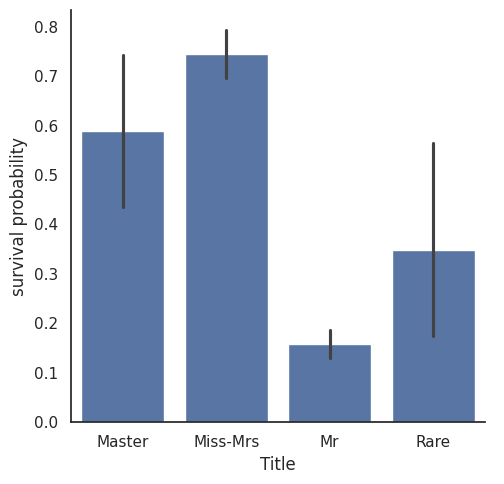

In [ ]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [ ]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Family size

In [ ]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

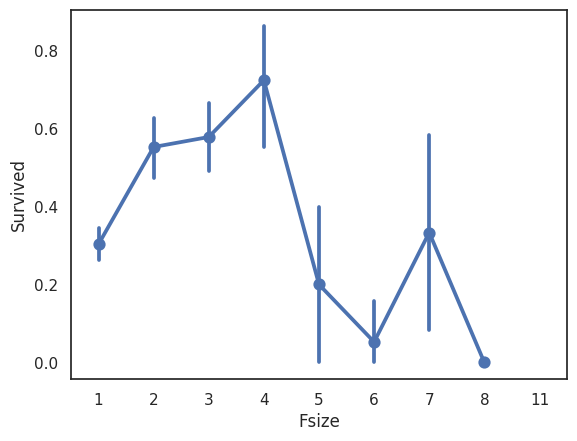

In [ ]:
sns.pointplot(x="Fsize", y="Survived", data=dataset) # pointplot으로 변경
g.set_ylabels("Survival Probability")

In [ ]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s ==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

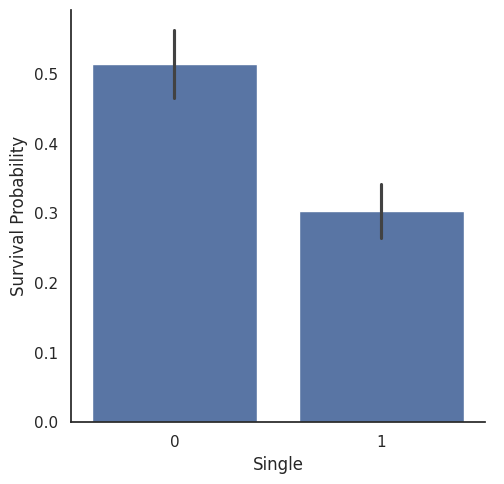

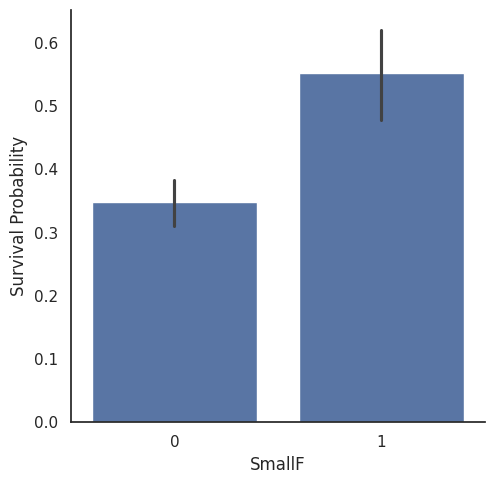

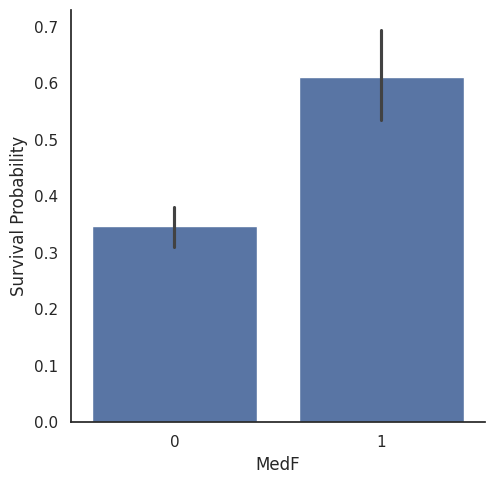

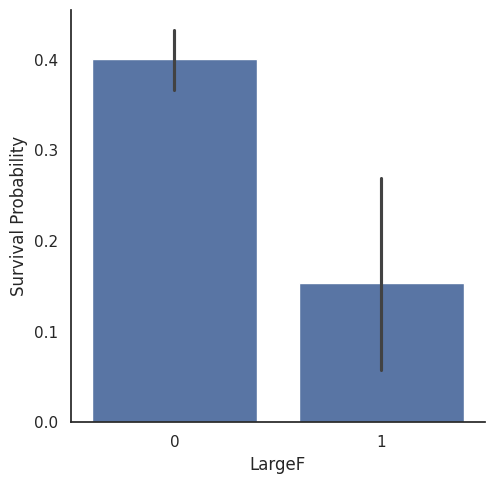

In [ ]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [ ]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

> 알게 된 것

* `prefix="Em"`: → 새 컬럼 이름에 접두사 붙임

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


### 5.3 Cabin

In [ ]:
dataset["Cabin"].head()

,Cabin
0,NaN
1,C85
2,NaN
3,C123
4,NaN


In [ ]:
dataset["Cabin"].describe()

,Cabin
count,292
unique,186
top,G6
freq,5


In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

,Cabin
1,C85
3,C123
6,E46
10,G6
11,C103


In [ ]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

/tmp/ipython-input-54-2160130155.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(x="Cabin", data=dataset, palette="Set2", order=['A','B','C','D','E','F','G','T','X'])


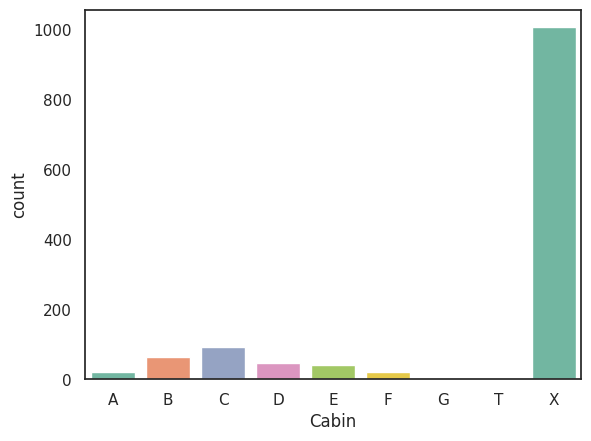

In [ ]:
g = sns.countplot(x="Cabin", data=dataset, palette="Set2", order=['A','B','C','D','E','F','G','T','X'])

> 알게 된 것

* 소수 승객을 보유한 cabin은 분산값이 크기에 cabin 자체가 생존율에 유의미한지 판단 보류
* 그래도 cabin값이 없는 집단 < cabin값이 있는 집단 생존율이 더 큰 것 확인 가능

> 알게 된 것

* 챗지피티가 알려주는 팔레트 색상

| 팔레트 이름      | 특징           |
| ----------- | ------------ |
| `"Set1"`    | 9개 카테고리, 강렬  |
| `"Set2"`    | 8개 카테고리, 은은  |
| `"Set3"`    | 12개 카테고리, 다양 |
| `"Paired"`  | 쌍으로 된 대비 색상  |
| `"Pastel1"` | 9개 파스텔톤      |
| `"Pastel2"` | 8개 파스텔톤      |
| `"Accent"`  | 8개 고대비 색상    |


/tmp/ipython-input-55-93368083.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(y="Survived", x="Cabin", data=dataset, palette="Set2", kind="bar", order=['A','B','C','D','E','F','G','T','X'])


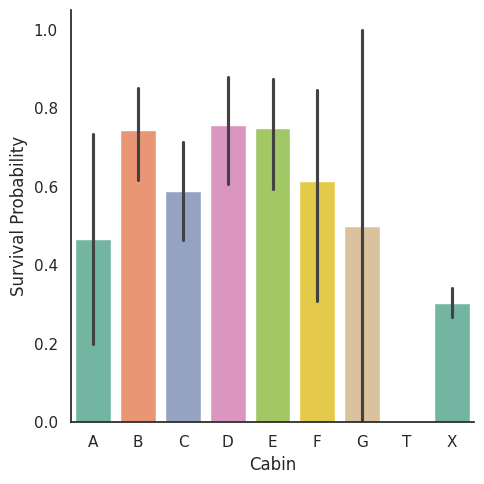

In [ ]:
g = sns.catplot(y="Survived", x="Cabin", data=dataset, palette="Set2", kind="bar", order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [ ]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin")

### 5.4 Ticket

In [ ]:
dataset["Ticket"].head()

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450


> 알게 된 것

* (좋았던 점) 같은 접두사 = 비슷한 클래스나 생존율을 보유했을 것이라는 추론
* 너무 경우의 수가 많은가? 했는데 unique() 생각보다 많이 없어서 괜찮겠다 싶음

In [ ]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace(".", "").replace("/","").strip().split(' ')[0])
  else:
    Ticket.append("X")
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

,Ticket
0,A5
1,PC
2,STONO2
3,X
4,X


In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [ ]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

> 알게 된 것

* `astype("category")`: Pclass의 데이터 타입을 카테고리형(Categorical) 으로 변환

In [ ]:
# Drop useless variables
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,False,False,False,False,False,False,False,True,False,False
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,False,True,False,False,False,False,False,False,False,True
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,False,False,False,False,False,False,True,True,False,False
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,False,False,False,False,False,False,True,False,False,True


## 6. MODELING

In [ ]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/tmp/ipython-input-76-1673638405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


In [ ]:
## Separate train features and label

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"], axis = 1)

/tmp/ipython-input-77-1626618683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


### 6.1 Simple modeling


#### 6.1.1 Cross validate models

각 모델의 평균 정확도(mean accuracy)를 Stratified K-Fold 교차검증으로 평가

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/tmp/ipython-input-83-3620265190.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(


Text(0.5, 1.0, 'Cross validation scores')

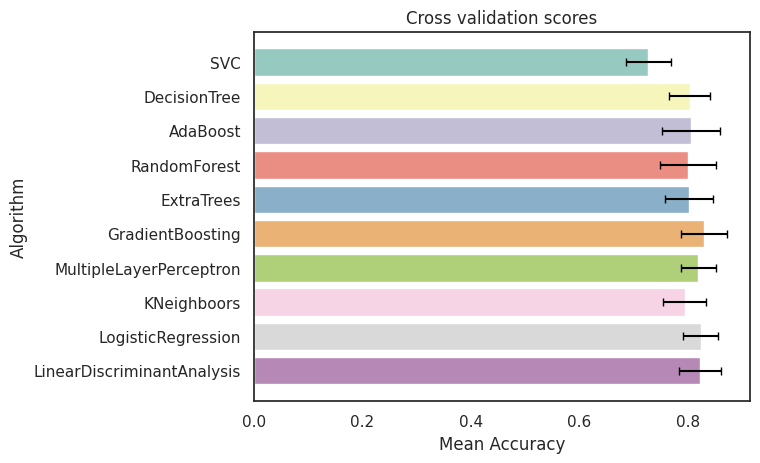

In [ ]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(
    x="CrossValMeans", y="Algorithm",
    data=cv_res, palette="Set3", orient="h"
)

# 에러바 수동 추가
for idx, (mean, std) in enumerate(zip(cv_res["CrossValMeans"], cv_res["CrossValerrors"])):
    plt.errorbar(mean, idx, xerr=std, fmt='none', c='black', capsize=3)

g.set_xlabel("Mean Accuracy")
g.set_title("Cross validation scores")

> 알게 된 것

* `매개변수 random_state`: 내부 무작위성 통제
* `n_jobs 파라미터`: 몇 개의 CPU 코어를 병렬 처리에 쓸지 지정

> Adaboost

* 기본 모델로 결정 트리를 사용한 부스팅(앙상블 기법)
  * 여러 개의 **“약한 학습기(weak learner)”**를 결합해 강한 학습기(strong learner)를 만드는 앙상블 기법
  * 여러 약한 모델들을 순차적 학습 -> 이전 모델이 틀린 데이터에 더 가중치를 주어 다음 모델이 집중
  * 여러 모델을 가중치 합(weighted sum)해서 최종 예측
*`learning_rate=0.1`: 학습률(모델이 새 약한 학습기에 얼마만큼 의존할지 조절)
  * 값이 작을수록 각 모델의 영향력이 작아지며, 더 많은 약한 학습기를 필요로 한다.
  * but 그만큼 과적합 위험이 적음

> 기반 방식 분류

| 분류           | 모델                                                                     |
| ------------ | ---------------------------------------------------------------------- |
| **선형 모델**    | Logistic Regression, Linear Discriminant Analysis (LDA)                |
| **트리 기반 모델** | Decision Tree, Random Forest, Extra Trees, Gradient Boosting, AdaBoost |
| **인스턴스 기반**  | K-Nearest Neighbors (KNN)                                              |
| **신경망 기반**   | Multi-Layer Perceptron (MLPClassifier)                                 |
| **마진 기반**    | Support Vector Classifier (SVC)                                        |


> 앙상블 여부

| 분류         | 모델                                                      |
| ---------- | ------------------------------------------------------- |
| **앙상블 아님** | SVC, Decision Tree, Logistic Regression, LDA, KNN, MLP  |
| **앙상블**    | Random Forest, Extra Trees, AdaBoost, Gradient Boosting |


> 요약표

| 모델                           | 기반 방식   | 앙상블 여부 | 복잡도 |
| ---------------------------- | ------- | ------ | --- |
| Logistic Regression          | 선형      | ❌      | 단순  |
| Linear Discriminant Analysis | 선형      | ❌      | 단순  |
| KNN                          | 인스턴스 기반 | ❌      | 단순  |
| Decision Tree                | 트리 기반   | ❌      | 단순  |
| SVC                          | 마진 기반   | ❌      | 중간  |
| Random Forest                | 트리 기반   | ✅      | 중간  |
| Extra Trees                  | 트리 기반   | ✅      | 중간  |
| AdaBoost                     | 트리 기반   | ✅      | 복잡  |
| Gradient Boosting            | 트리 기반   | ✅      | 복잡  |
| MLPClassifier                | 신경망 기반  | ❌      | 복잡  |


> (1) SVC와 LDA의 차이는 무엇일까?

* ✅ SVC: 마진 최대화, 비선형 가능, Support Vectors에 집중
* ✅ LDA: 클래스 평균과 분산 기반 선형 경계, 데이터 분포 가정 필요

| 상황                  | 유리한 모델 |
| ------------------- | ------ |
| 데이터가 **비선형 패턴** 있음  | SVC    |
| 데이터가 **정규분포 가정 만족** | LDA    |
| 빠르고 해석 쉬운 모델 필요     | LDA    |
| 고차원 feature 많음      | SVC    |


> (2) Decision Tree vs Random Forest vs Extra Trees

| 구분        | Decision Tree | Random Forest             | Extra Trees             |
| --------- | ------------- | ------------------------- | ----------------------- |
| **구조**    | 단일 트리         | 여러 트리(앙상블)                | 여러 트리(앙상블)              |
| **분할 방식** | 정보 이득 최대화     | 무작위로 feature 일부 선택 + 정보이득 | 완전히 무작위로 feature+분할점 선택 |
| **과적합**   | 높음            | 낮음                        | 더 낮음                    |
| **속도**    | 빠름            | 느림                        | Random Forest보다 빠름      |
| **정확도**   | 낮음            | 높음                        | 비슷하거나 약간 낮음             |

* 특성 무작위 선택이란
  * 각 의사결정나무를 학습시킬 때, 모든 특성을 사용하는 것이 아니라 일부 특성만 무작위로 선택하여 학습. 이를 통해 나무들 사이의 상관관계를 줄이고, 다양성을 증가.
* RF와 ET의 차이
  * 1. Split Random ( RF - Split best)
    * 분할 점 랜덤 선택 (최적 분할점 계산X)
  * 2. Bootstrap X ( RF - Bootstratp O)
    * ET는 모든 데이터를 사용하여 학습한다.
* ET 왜 사용하는거임?
  * 편향(bias) 증가 (분할점까지 랜덤이기에)
  * 분산(Variation)의 감소(랜덤 피쳐 선택, 랜덤 분할 계산, 앙상블)
  * 계산이 빠름
  * 성능은 낮아지나 과대적합 막고 검증세트 점수를 높이는 효과 존재 (그래서 테스트에서 많이 사용하나?)

> 3. AdaBoost vs Gradient Boosting

* AdaBoost (단순, 빠름)
  * 잘못 분류한 데이터에 가중치↑ → 새 모델이 이 어려운 샘플에 집중
  * 단점: 이상치(outlier)에 매우 민감

* Gradient Boosting (유연, 강력, 느림)
  * 각 모델이 이전 모델의 **잔차(오류)**를 예측하도록 학습
  * 손실 함수를 gradient로 최소화

| 차이 포인트       | AdaBoost               | Gradient Boosting        |
| ------------ | ---------------------- | ------------------------ |
| **에러 처리**    | 샘플 가중치만 조정             | 손실 함수의 gradient 사용       |
| **이상치 민감도**  | 높음                     | 낮음 (loss에 따라 튜닝 가능)      |
| **학습률 조정**   | 없음 (약한 학습기 영향력 그대로 반영) | 있음 (`learning_rate`로 조절) |
| **손실 함수 종류** | 고정 (Exponential Loss)  | 유연 (사용자가 정의 가능)          |



> 4. MLP는 언제 유리한가?

| 상황                         | MLP 유리함?   |
| -------------------------- | ---------- |
| 데이터에 **비선형 관계**가 많을 때      | ✅          |
| 입력 feature가 많고 상호작용이 복잡할 때 | ✅          |
| 데이터 양이 충분히 많을 때            | ✅          |
| 소규모 데이터셋                   | ❌ (과적합 위험) |
| 해석이 중요한 상황                 | ❌          |


#### 6.1.2 Hyperparameter tunning for best models


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


# 기본 약한 학습기
DTC = DecisionTreeClassifier()

# AdaBoost 모델 정의 (base_estimator → estimator)
adaDTC = AdaBoostClassifier(estimator=DTC, random_state=7)

# 파라미터 그리드 (base_estimator__ → estimator__로 변경)
ada_param_grid = {
    "estimator__criterion": ["gini", "entropy"],
    "estimator__splitter": ["best"],  # 최신버전: "random" 제거 권장
    "algorithm": ["SAMME", "SAMME.R"],
    "n_estimators": [50, 100, 200],   # [1,2] 대신 실사용 가능한 값
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3, 1.0]
}

# GridSearchCV 정의
gsadaDTC = GridSearchCV(
    adaDTC,
    param_grid=ada_param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=4,
    verbose=1
)

# 최적 모델 학습
gsadaDTC.fit(X_train, Y_train)

# 최고 성능 AdaBoost 모델 추출
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

> 파라미터 해석

| 파라미터                        | 설명                                                    |
| --------------------------- | ----------------------------------------------------- |
| `base_estimator__criterion` | 분할 품질 평가 방법: 지니불순도 or 엔트로피                            |
| `base_estimator__splitter`  | 분할 전략: 최적(best) or 무작위(random)                        |
| `algorithm`                 | AdaBoost 방식: `SAMME`(분류기 앙상블) or `SAMME.R`(확률 예측 앙상블) |
| `n_estimators`              | 약한 학습기(결정트리) 개수                                       |
| `learning_rate`             | 각 트리 기여도(학습률) 조절                                      |

> 알고리즘 방식 선택

| 값           | 설명                                       |
| ----------- | ---------------------------------------- |
| **SAMME**   | Multi-class AdaBoost (분류 클래스 여러 개 처리 가능) |
| **SAMME.R** | 확률 예측(Log odds)을 기반으로 가중치 업데이트 → 더 정확    |


> GridSearchCV

* 모든 파라미터 조합 시도
* cv=kfold: Stratified K-Fold 교차검증 사용
* scoring="accuracy": 정확도로 평가
* n_jobs=4: 4코어 병렬 처리
* verbose=1: 진행 상황 출력

In [ ]:
gsadaDTC.best_score_

In [ ]:
# ExtraTrees

ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


np.float64(0.8308605720122575)

> 해석

* max_depth: [None]
  * 의미: 트리의 최대 깊이 제한
  * 제한이 없음 과적합 가능성이 높다
* max_features: [1, 3, 10]
  * 의미: 각 노드 분할 시 고려할 feature 개수
  * 값이 작으면 모델 다양성이 높고, 과적합이 적음
* min_samples_split: [2, 3, 10]
  * 의미: 노드를 분할하기 위한 최소 샘플 수
  * 값 크면 트리 덜 복잡해져 과적합이 적음
* min_samples_leaf: [1, 3, 10]
  * 의미: 리프 노드에 있어야 할 최소 샘플 수
  * 값이 크면 모델 단순 -> 과적합 방지


In [ ]:
# RFC Parameters tunning
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


ValueError: 
All the 720 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
561 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.

--------------------------------------------------------------------------------
159 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.


> 해석

* loss: ["deviance"]
  * 의미: 손실 함수 선택
* max_depth: [4, 8]
  * 의미: 개별 트리의 최대 깊이
* min_samples_leaf: [100, 150]
  * 의미: 리프 노드에 있어야 할 최소 샘플 수


In [ ]:
### SVC classifier

SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


np.float64(0.8331332992849847)

> 해석

* probability = True
  * SVC 기본은 클래스 확률을 출력 못 함
  * probability=True 하면 확률 예측 가능
* kernel: ['rbf']
  * 의미: SVM에서 사용할 커널 함수
  * 값
    * 'rbf': Radial Basis Function (가우시안 커널)
* gamma: [0.001, 0.01, 0.1, 1]
  * 의미: RBF 커널의 감도 (결정 경계의 유연성 조절)
  * 작을수록 경계 부드러움, 클수록 경계 복잡하며 과적합 커짐
* C: [1, 10, 50, 100, 200, 300, 1000]
  * 의미: 규제 강도 (마진 폭과 오분류 트레이드오프)
  * 작을수록 규제 강함, 단순 경계 (마진 폭 넓고 오분류 허용)

#### 6.1.3 Plot learning curves

> 러닝 커브란

* 훈련 데이터 크기를 늘려가면서
  * 훈련 정확도(training score)
  * 검증 정확도(validation score) 를 기록해 그래프로 그린 것

| 상황        | 그래프 특징               |
| --------- | -------------------- |
| **과적합**   | 훈련 정확도 ↑↑, 검증 정확도 낮음 |
| **과소적합**  | 훈련, 검증 모두 낮음         |
| **잘 학습함** | 훈련·검증 정확도가 비슷하고 높음   |


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

NameError: name 'gsRFC' is not defined

> 해석

* AdaBoost & GradientBoosting → 과적합 경향, 데이터 더 있으면 개선 가능함
  * 부스팅 같은 경우 훈련샘플수가 증가할수록 훈련 점수와 검증 점수 격차가 생김
* SVC & ExtraTrees → 과적합 적고 안정적
  * 두 점수가 샘플수가 증가할수록 비슷해지고 있으며, 훈련 스코어가 압도적으로 높진 않음

#### 6.1.4 Feature importance of tree based classifiers

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

> 해석

* 공통적으로 'Fare', 'Title_2', 'Age' and 'Sex' 피쳐가 높게 나타남.
* 즉, 객실 위치(Cabin 등)는 생존과 약한 상관
* 사회적/개인적 속성이 더 결정적인 역할

| Feature                     | 의미                            |
| --------------------------- | ----------------------------- |
| Pc\_1, Pc\_2, Pc\_3, Fare   | 탑승객의 사회적 지위 (1,2,3등석과 요금)     |
| Sex, Title\_2, Title\_3     | 성별 정보 (남성: Mr, 여성: Miss 등)    |
| Age, Title\_1               | 나이 정보 (Master는 어린 남자아이에게 사용됨) |
| Fsize, LargeF, MedF, Single | 가족 규모 정보                      |


In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

> 해석

* 예측이 약간씩 다르기 때문에 여러 모델의 예측을 합쳐서 다수결 투표(voting)를 하면 개별 모델의 약점을 상쇄 성능 향상 기대



### 6.2 Ensemble modeling

#### 6.2.1 Combining models

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

> 보팅 방식

| 구분     | Hard Voting  | Soft Voting              |
| ------ | ------------ | ------------------------ |
| 투표 기준  | 다수결(클래스 레이블) | 확률 평균                    |
| 확률 필요? | ❌            | ✅ (predict\_proba 지원 필요) |
| 세밀함    | 낮음 (확률 무시)   | 높음 (확률 고려)               |
| 장점     | 모든 분류기 사용 가능 | 더 부드럽고 정확한 예측 가능         |
| 단점     | 확률 정보 손실     | 확률 계산 불가능한 모델 제외됨        |


### 6.3 Prediction

#### 6.3.1 Predict and Submit results

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)